In [1]:
# mounting to drive to use colab
from google.colab import drive
drive.mount('/content/drive')

# load model, tokenizer
!pip install transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import TrainingArguments, Trainer
from transformers import set_seed
from transformers import BertTokenizer, BertForSequenceClassification

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
     "bert-base-uncased", 
     num_labels = 2, 
)

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

from sklearn.model_selection import train_test_split
import torch
import random



Mounted at /content/drive
     |████████████████████████████████| 4.2 MB 5.1 MB/s 
     |████████████████████████████████| 6.6 MB 9.1 MB/s 
     |████████████████████████████████| 84 kB 2.6 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [2]:
torch.cuda.empty_cache()

set_seed(42)
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [3]:
# get all preprocessed test datasets - updated when labels became available

test_in_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_IN_labels.csv'
test_out1_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_OUT1_labels.csv'
test_out2_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_OUT2_labels.csv'
test_textgain_labels_path = 'drive/MyDrive/NLP_Final_Assignment/data/test_TEXTGAIN_labels.csv'

test_in = pd.read_csv(test_in_labels_path, sep=',', header=0)
test_out1 = pd.read_csv(test_out1_labels_path, sep=',', header=0)
test_out2 = pd.read_csv(test_out2_labels_path, sep=',', header=0)
test_textgain = pd.read_csv(test_textgain_labels_path, sep=',', header=0)

In [4]:
test_in = test_in[['id', 'tweet_clean', 'offensive']]
test_in = test_in.set_index('id')
test_in.rename({'tweet_clean': 'text'}, axis=1, inplace=True)

test_out1 = test_out1[['id', 'tweet_clean', 'offensive']]
test_out1 = test_out1.set_index('id')
test_out1.rename({'tweet_clean': 'text'}, axis=1, inplace=True)

test_out2 = test_out2[['id', 'tweet_clean', 'offensive']]
test_out2 = test_out2.set_index('id')
test_out2.rename({'tweet_clean': 'text'}, axis=1, inplace=True)

test_textgain = test_textgain[['id', 'tweet_clean', 'offensive']]
test_textgain = test_textgain.set_index('id')
test_textgain.rename({'tweet_clean': 'text'}, axis=1, inplace=True)

In [5]:
# Tokenize data
test_in_test = list(test_in['text'])
test_out1_test = list(test_out1['text'])
test_out2_test = list(test_out2['text'])
test_textgain_test = list(test_textgain['text'])

test_in_test_tokenized = tokenizer(test_in_test, padding=True,  add_special_tokens=True, truncation=True)
test_out1_test_tokenized = tokenizer(test_out1_test, padding=True,  add_special_tokens=True, truncation=True)
test_out2_test_tokenized = tokenizer(test_out2_test, padding=True,  add_special_tokens=True, truncation=True)
test_textgain_test_tokenized = tokenizer(test_textgain_test, padding=True,  add_special_tokens=True, truncation=True)


In [6]:
print(len(test_in_test))
print(len(test_out1_test))
print(len(test_out2_test))
print(len(test_textgain_test))

860
1207
1200
1276


In [7]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):    
    def __init__(self, encodings, labels=None):          
        self.encodings = encodings        
        self.labels = labels
     
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
      return len(self.encodings["input_ids"])

In [8]:
# Create torch dataset
test_in_dataset = Dataset(test_in_test_tokenized)
test_out1_dataset = Dataset(test_out1_test_tokenized)
test_out2_dataset = Dataset(test_out2_test_tokenized)
test_textgain_dataset = Dataset(test_textgain_test_tokenized)

In [9]:
# Load trained model
model_path = "drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/checkpoint-3500"
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

**In-domain Twitter Data**

In [10]:
args = TrainingArguments(
    output_dir="drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2",
    evaluation_strategy="epoch",
    per_device_train_batch_size=32,
    learning_rate=1e-6,
    do_train=True,
    do_eval=True,
    warmup_steps=0,
    num_train_epochs=15,
    adam_epsilon=1e-8,
    metric_for_best_model = 'f1',
    logging_dir = 'drive/MyDrive/NLP_Final_Assignment/bertmodel_maxlen2/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

In [11]:
# Define test trainer
test_trainer = Trainer(model, args)

# Make prediction - in domain dataset
test_in_raw_pred, _, _ = test_trainer.predict(test_in_dataset)

# Preprocess raw predictions
test_in_y_pred = np.argmax(test_in_raw_pred, axis=1)

***** Running Prediction *****
  Num examples = 860
  Batch size = 8


In [12]:
# add predictions to the dataset
test_in_y_pred  = pd.DataFrame(test_in_y_pred)
test_in = test_in.reset_index()
test_in['test_in_y_pred'] = test_in_y_pred

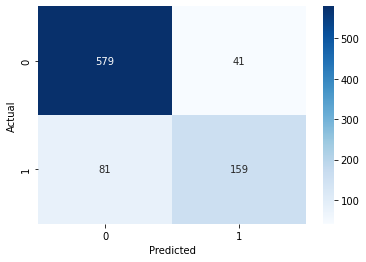

In [13]:
# print the confusion matrix
confusion_matrix = pd.crosstab(test_in['offensive'], test_in['test_in_y_pred'], rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

In [14]:
# print the classification report, model metrics
print(classification_report(test_in['offensive'], test_in['test_in_y_pred'], digits=3))

              precision    recall  f1-score   support

           0      0.877     0.934     0.905       620
           1      0.795     0.662     0.723       240

    accuracy                          0.858       860
   macro avg      0.836     0.798     0.814       860
weighted avg      0.854     0.858     0.854       860



In [15]:
test_in_neural = test_in[test_in[['id', 'offensive', 'test_in_y_pred']].notnull()].copy()
test_in_neural = test_in_neural[['id', 'offensive', 'test_in_y_pred']]
test_in_neural['test_in_y_pred'] = test_in_neural['test_in_y_pred'].map({1: 'OFF', 0: 'NOT'})
test_in_neural['offensive'] = test_in_neural['offensive'].map({1: 'OFF', 0: 'NOT'})
test_in_neural.rename({'test_in_y_pred': 'predicted_label', 'offensive': 'label'}, axis=1, inplace=True)
test_in_neural.head()

,id,label,predicted_label
0,15923,OFF,NOT
1,27014,NOT,NOT
2,30530,NOT,NOT
3,13876,NOT,NOT
4,60133,OFF,NOT


In [ ]:
# write out predictions
test_in_neural_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_in_neural_final.csv'
test_in_neural.to_csv(test_in_neural_path, encoding='utf-8', index=False)

**Out-domain Data 1 - Reddit**

In [16]:
# Make prediction - out-domain dataset Reddit
test_out1_raw_pred, _, _ = test_trainer.predict(test_out1_dataset)

# Preprocess raw predictions
test_out1_y_pred = np.argmax(test_out1_raw_pred, axis=1)

***** Running Prediction *****
  Num examples = 1207
  Batch size = 8


In [17]:
# add predictions to the dataset
test_out1_y_pred  = pd.DataFrame(test_out1_y_pred)
test_out1 = test_out1.reset_index()
test_out1['test_out1_y_pred'] = test_out1_y_pred

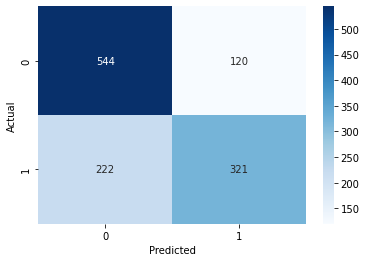

In [18]:
# print the confusion matrix
confusion_matrix = pd.crosstab(test_out1['offensive'], test_out1['test_out1_y_pred'], rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

In [31]:
# print the classification report, model metrics
print(classification_report(test_out1['offensive'], test_out1['test_out1_y_pred'], digits=3))

              precision    recall  f1-score   support

           0      0.710     0.819     0.761       664
           1      0.728     0.591     0.652       543

    accuracy                          0.717      1207
   macro avg      0.719     0.705     0.707      1207
weighted avg      0.718     0.717     0.712      1207



In [20]:
test_out1_neural = test_out1[test_out1[['id', 'offensive', 'test_out1_y_pred']].notnull()].copy()
test_out1_neural = test_out1_neural[['id', 'offensive', 'test_out1_y_pred']]
test_out1_neural['test_out1_y_pred'] = test_out1_neural['test_out1_y_pred'].map({1: 'OFF', 0: 'NOT'})
test_out1_neural['offensive'] = test_out1_neural['offensive'].map({1: 'OFF', 0: 'NOT'})
test_out1_neural.rename({'test_out1_y_pred': 'predicted_label', 'offensive': 'label'}, axis=1, inplace=True)
test_out1_neural.head()

,id,label,predicted_label
0,37,OFF,OFF
1,127,OFF,OFF
2,143,OFF,NOT
3,146,OFF,OFF
4,186,OFF,OFF


In [ ]:
# write out predictions
test_out1_neural_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_out1_neural_final.csv'
test_out1_neural.to_csv(test_out1_neural_path, encoding='utf-8', index=False)

**Out-domain Data 2 - Wikipedia**

In [21]:
# Make prediction - out-domain dataset wikipedia
test_out2_raw_pred, _, _ = test_trainer.predict(test_out2_dataset)

# Preprocess raw predictions
test_out2_y_pred = np.argmax(test_out2_raw_pred, axis=1)

***** Running Prediction *****
  Num examples = 1200
  Batch size = 8


In [22]:
# add predictions to the dataset
test_out2_y_pred  = pd.DataFrame(test_out2_y_pred)
test_out2 = test_out2.reset_index()
test_out2['test_out2_y_pred'] = test_out2_y_pred

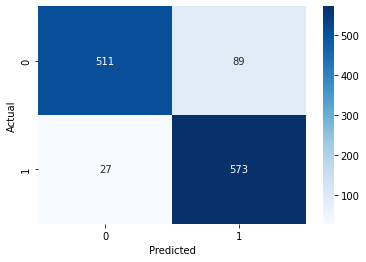

In [23]:
# print the confusion matrix
confusion_matrix = pd.crosstab(test_out2['offensive'], test_out2['test_out2_y_pred'], rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

In [32]:
# print the classification report, model metrics
print(classification_report(test_out2['offensive'], test_out2['test_out2_y_pred'], digits=3))

              precision    recall  f1-score   support

           0      0.950     0.852     0.898       600
           1      0.866     0.955     0.908       600

    accuracy                          0.903      1200
   macro avg      0.908     0.903     0.903      1200
weighted avg      0.908     0.903     0.903      1200



In [25]:
test_out2_neural = test_out2[test_out2[['id', 'offensive', 'test_out2_y_pred']].notnull()].copy()
test_out2_neural = test_out2_neural[['id', 'offensive', 'test_out2_y_pred']]
test_out2_neural['test_out2_y_pred'] = test_out2_neural['test_out2_y_pred'].map({1: 'OFF', 0: 'NOT'})
test_out2_neural['offensive'] = test_out2_neural['offensive'].map({1: 'OFF', 0: 'NOT'})
test_out2_neural.rename({'test_out2_y_pred': 'predicted_label', 'offensive': 'label'}, axis=1, inplace=True)
test_out2_neural.head()

,id,label,predicted_label
0,0072b9c3697ab8cc,OFF,OFF
1,0081b14d79f54b31,OFF,OFF
2,008eb47c4684d190,OFF,OFF
3,010c2a979fab2e3f,OFF,OFF
4,01680b05bde74236,NOT,NOT


In [ ]:
# write out predictions
test_out2_neural_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_out2_neural_final.csv'
test_out2_neural.to_csv(test_out2_neural_path, encoding='utf-8', index=False)

**TextGain Test Data**

In [26]:
# Make prediction - textgain dataset
test_textgain_raw_pred, _, _ = test_trainer.predict(test_textgain_dataset)

# Preprocess raw predictions
test_textgain_y_pred = np.argmax(test_textgain_raw_pred, axis=1)

***** Running Prediction *****
  Num examples = 1276
  Batch size = 8


In [27]:
# add predictions to the dataset
test_textgain_y_pred  = pd.DataFrame(test_textgain_y_pred)
test_textgain = test_textgain.reset_index()
test_textgain['test_textgain_y_pred'] = test_textgain_y_pred

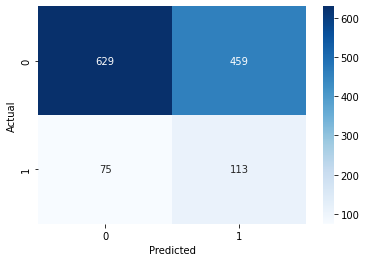

In [28]:
# print the confusion matrix
confusion_matrix = pd.crosstab(test_textgain['offensive'], test_textgain['test_textgain_y_pred'], rownames=['Actual'], colnames=['Predicted']) 
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.show()

In [33]:
# print the classification report, model metrics
print(classification_report(test_textgain['offensive'], test_textgain['test_textgain_y_pred'], digits=3))

              precision    recall  f1-score   support

           0      0.893     0.578     0.702      1088
           1      0.198     0.601     0.297       188

    accuracy                          0.582      1276
   macro avg      0.546     0.590     0.500      1276
weighted avg      0.791     0.582     0.642      1276



In [30]:
~ test_textgain_neural = test_textgain[test_textgain[['id', 'offensive', 'test_textgain_y_pred']].notnull()].copy()
test_textgain_neural = test_textgain_neural[['id', 'offensive', 'test_textgain_y_pred']]
test_textgain_neural['test_textgain_y_pred'] = test_textgain_neural['test_textgain_y_pred'].map({1: 'OFF', 0: 'NOT'})
test_textgain_neural['offensive'] = test_textgain_neural['offensive'].map({1: 'OFF', 0: 'NOT'})
test_textgain_neural.rename({'test_textgain_y_pred': 'predicted_label', 'offensive': 'label'}, axis=1, inplace=True)
test_textgain_neural.head()

,id,label,predicted_label
0,0,NOT,NOT
1,1,OFF,OFF
2,2,OFF,OFF
3,3,NOT,OFF
4,4,NOT,NOT


In [ ]:
# write out predictions
test_textgain_neural_path = 'drive/MyDrive/NLP_Final_Assignment/predictions/test_textgain_neural_final.csv'
test_textgain_neural.to_csv(test_textgain_neural_path, encoding='utf-8', index=False)